# Запуск MLFlow

In [ ]:
!mlflow server --host 0.0.0.0 --port 5000

In [38]:
!hostname -I

10.22.27.128 172.17.0.1 


# Параметры блокнота

In [1]:
EPOCHS = 70
BATCH_SIZE = 4
NUM_WORKERS = 4

# Импорты

In [2]:
import os
import glob
import torch
import json
import mlflow
import datetime
import random
import albumentations as A
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.gridspec as grids
import torchvision.transforms as T
import torchvision.transforms.functional as F
import segmentation_models_pytorch as smp
from torchinfo import summary
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from mlflow.models import infer_signature

%matplotlib inline

mlflow.set_tracking_uri("http://localhost:5000")

/home/prokofev.a@agtu.ru/Загрузки/qgis temp/Обучение моделей/learn_cycle/.venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Класс Датасета

In [3]:
class MyDataset(Dataset):
    def __init__(self, root, transform=None, debug=False, layerNames=('one', 'two', 'ssrd', 'strd', 'e', 'u10', 'v10', 't2m', 'sst', 'sp', 'rsn', 'sd', 'lsm'), maskNames=('CT', 'CA', 'CB', 'CC', 'SA', 'SB', 'SC', 'CN', 'CD', 'FA', 'FB', 'FC', 'CF'), ignoreValues=(-9, 99)):
        super(MyDataset, self).__init__()
        self.__root = root
        self.__transform = transform
        self.__layerNames = layerNames
        self.__maskNames = maskNames
        self.__maskClasses = []
        self.__ignoreValues = ignoreValues
        self.__debug = debug
        self.__time = None
        self.__tqdm = None

        if self.__debug:
            self.log(f"{self.getTimeExecution()} параметры инициализированы")
        
        self.__ice_types = pd.read_csv(self.__root + "/ice_types.csv", index_col=0, dtype=np.int32)

        if self.__debug:
            self.log(f"{self.getTimeExecution()} прочитаны параметры льда")

        mask = [np.any([(self.__ice_types[i] == v) for v in self.__ignoreValues], axis=0) for i in self.__maskNames]
        ignore = [str(i) for i in self.__ice_types[np.any(mask, axis=0)].index]
        self.__ice_types = self.__ice_types[np.any(mask, axis=0) == False]
        self.__ice_types = self.__ice_types[maskNames]

        imageStatistic = pd.read_csv(self.__root + '/statistic.csv', index_col=0)
        mask = [imageStatistic.uniques.str.contains(i) == False for i in ignore]
        self.__image_files = imageStatistic[np.all(mask, axis=0)].image.tolist()

        self.log(f"{self.getTimeExecution()} Найдено {len(self.__image_files)} изображений.")     

        #with open('ice_types_dict.json', 'r', encoding='utf-8-sig') as f:
        #    ice_dict = json.load(f)
        #for cat in ice_dict['fields'].keys():
        #    vals = [int(i) for i in ice_dict['cifer'][cat].keys()]
        #    for field in ice_dict['fields'][cat]:
        #        self.__ice_types[field] = self.__ice_types[field].map(dict(zip(vals, [i / (len(vals) - 1) for i in range(0, len(vals))] )))

        for field in self.__maskNames:
            un = np.sort(self.__ice_types[field].unique()).tolist()
            self.__maskClasses.append(len(un))
            self.__ice_types[field] = self.__ice_types[field].map(dict(zip(un, np.linspace(0, 1, len(un)).tolist())))

        
        if self.__debug:
            self.log(f"{self.getTimeExecution()} параметры льда проскалированы")
    
    def __len__(self):
        return len(self.__image_files)

    def getClassesPerLayer(self):
        return self.__maskClasses

    def getPaths(self):
        return self.__image_files

    def getLayers(self):
        return self.__layerNames, self.__maskNames

    def setTQDM(self, tqdm : tqdm):
        self.__tqdm = tqdm

    def log(self, msg):
        if self.__tqdm is None:
            print(msg)
        else:
            self.__tqdm.write(msg)

    def getTimeExecution(self):
        if self.__time is None:
            self.__time = datetime.datetime.now()
        delta = (datetime.datetime.now() - self.__time).total_seconds()
        self.__time = datetime.datetime.now()
        return delta

    def getItemByName(self, substr):
        for i in range(len(self.__image_files)):
            if substr in self.__image_files[i]:
                return self.__getitem__(i)

    def __getitem__(self, idx):
        try:
            if self.__debug:
                self.log(f"{self.getTimeExecution()} чтение файла {idx} {self.__image_files[idx]}")
            data = gpd.read_file(f"{self.__root}/{self.__image_files[idx]}").sort_values(by=['point_id'])
            if self.__debug:
                self.log(f"{self.getTimeExecution()} прочитан файл {idx} {self.__image_files[idx]}")

            data['ice'] = data['ice'].astype(np.int32)
            data = data.join(self.__ice_types, on='ice', how='left')
            if self.__debug:
                self.log(f"{self.getTimeExecution()} файл {idx} соединён с типами льда {self.__image_files[idx]}")
            
            data = data.rename(columns={"vv": "one", "hh": "one", "vh": "two", "hv": "two"})

            if self.__debug:
                self.log(f"{self.getTimeExecution()} в файле {idx} переименованы колонки {self.__image_files[idx]}")

            for layer in self.__layerNames:
                if data[layer].isna().any(axis=0):
                    mean = data[layer][data[layer].notna()].mean()
                    mean = 0 if mean is np.nan else mean
                    data[layer] = data[layer].fillna(mean)
                    if self.__debug:
                        self.log(f"{self.getTimeExecution()} в файле {idx} были значения nan {self.__image_files[idx]}")

            image_channels = []
            for layer in self.__layerNames:
                image_channels.append(np.reshape(data[layer].to_numpy(dtype=np.float32), (1000, 1000), order="F"))
            image = np.stack(image_channels, axis=-1)

            if self.__debug:
                self.log(f"{self.getTimeExecution()} сформированы слои image файла {idx} {self.__image_files[idx]}")

            mask_channels = []
            for layer in self.__maskNames:
                mask_channels.append(np.reshape(data[layer].to_numpy(dtype=np.float32), (1000, 1000), order="F"))
            mask = np.stack(mask_channels, axis=-1)

            if self.__debug:
                self.log(f"{self.getTimeExecution()} сформированы слои mask файла {idx} {self.__image_files[idx]}")

            if self.__transform:
                image = torch.cat((self.__transform[0](image[:,:,:2]), self.__transform[1](image[:,:,2:])))
                mask = self.__transform[2](mask)

                if self.__debug:
                    self.log(f"{self.getTimeExecution()} применены трансформы {idx} {self.__image_files[idx]}")

        except KeyError as e:
            self.log(f"ошибка при чтении файла {self.__image_files[idx]}: {e}")

        return image, mask

# Расчёт min, max, mean и std набора

In [4]:
dataset = MyDataset(
    root='/home/prokofev.a@agtu.ru/Загрузки/qgis temp/Обучение моделей/dataset',
    transform=[T.ToTensor()] * 3
)
parameters = {i: {"min": 1e+30, 'max': 0, 'sum': 0} for i in dataset.getLayers()[0]}
loader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=False
)

4e-06 Найдено 1948 изображений.


In [ ]:
for images, _ in tqdm(loader):
    for idx, key in enumerate(parameters.keys()):
        parameters[key] = {
            'min': min(images[0][idx].min().item(), parameters[key]['min']),
            'max': max(images[0][idx].max().item(), parameters[key]['max']),
            'sum': parameters[key]['sum'] + images[0][idx].sum().item(),
            'd': 0,
            'std': 0
        }

In [8]:
with open('dataset_parameters.json', 'w') as f:
    json.dump(parameters, f, indent=4)

In [5]:
with open('dataset_parameters.json', 'r') as f:
    parameters = json.load(f)

In [ ]:
for key in parameters.keys():
    parameters[key]['mean'] = parameters[key]['sum'] / 1948000000

In [6]:
for images, labels in tqdm(loader):
    for key in parameters.keys():
        d = parameters[key]
        d['d'] += ((images - parameters[key]['mean']) ** 2).sum().item()
        parameters[key] = d

100%|██████████| 1948/1948 [3:05:00<00:00,  5.70s/it]  


In [ ]:
with open('dataset_parameters.json', 'w') as f:
    json.dump(parameters, f, indent=4)

In [10]:
for key in parameters.keys():
    parameters[key]['std'] = np.sqrt(parameters[key]['d'] / 1948000000)

In [11]:
with open('dataset_parameters.json', 'w') as f:
    json.dump(parameters, f, indent=4)

# Статистика изображений

In [20]:
from IPython.display import clear_output

statistic = pd.DataFrame({"image": [], 'uniques': []})
for path in tqdm(glob.glob("/home/prokofev.a@agtu.ru/Загрузки/qgis temp/Обучение моделей/dataset/*.gpkg")):
    print(statistic)
    statistic.loc[len(statistic), 'image'] = os.path.basename(path)
    statistic.loc[len(statistic) - 1, 'uniques'] = ", ".join([str(i) for i in gpd.read_file(path)['ice'].unique()])
    clear_output()

100%|██████████| 1948/1948 [2:58:11<00:00,  5.49s/it]


In [21]:
statistic.to_csv('statistic.csv')

# Больше классов трансформаций

## Случайный поворот изображения

In [4]:
class RandomRotation(torch.nn.Module):
    def __init__(self, counter=3,p=0.5):
        super(RandomRotation, self).__init__()
        self.__counter = counter
        self.__currentCounter = counter
        self.__result = 0
        self.__angle = 0
        self.__p = p
    
    def forward(self, obj: torch.Tensor):
        if self.__currentCounter == self.__counter:
            self.__result = torch.rand(1)
            self.__angle = random.choice([0, 90, 180, 270])

        self.__currentCounter -= 1

        if self.__currentCounter == 0:
            self.__currentCounter = self.__counter

        if self.__result < self.__p:
            return F.rotate(obj, self.__angle)
        return obj

## Скалирование от минимума до максимума

In [5]:
class MinMaxScaler(torch.nn.Module):
    def __init__(self, minimum, maximum):
        super(MinMaxScaler, self).__init__()
        self.__min = minimum
        self.__max = maximum
    
    def forward(self, obj: torch.Tensor):
        for index in range(obj.shape[0]):
            layer = obj[index].clone()
            obj[index] = (layer - self.__min[index]) / (self.__max[index] - self.__min[index] + 1e-8)
        return obj

## Выравнивание гистограммы

In [6]:
class HistogramEqualizer(torch.nn.Module):
    def __init__(self, bins=256):
        super(HistogramEqualizer, self).__init__()
        self.__bins = bins
    
    def forward(self, x):
        """
        Args:
            x: Tensor shape (..., H, W) - любой размерности
        Returns:
            Equalized tensor same shape as input
        """
        
        for index in range(x.shape[0]):
            layer = x[index].clone()
            orig_shape = layer.shape
            x_flat = layer.flatten()
            
            # Вычисляем min/max если не заданы
            min_val = x_flat.min()
            max_val = x_flat.max()
            
            # Нормализуем в [0, bins-1]
            x_norm = (x_flat - min_val) * (self.__bins - 1) / (max_val - min_val + 1e-8)
            x_norm = torch.clamp(x_norm, 0, self.__bins - 1)
            
            # Вычисляем гистограмму и CDF
            hist = torch.bincount(x_norm.to(torch.long), minlength=self.__bins)
            cdf = torch.cumsum(hist, dim=0)
            cdf_normalized = (cdf - cdf.min()) / (cdf.max() - cdf.min() + 1e-8)
            
            # Применяем эквализацию
            equalized = cdf_normalized[x_norm.to(torch.long)]
            x[index] = equalized.reshape(orig_shape)
        
        return x

## Частотная фильтрация

In [7]:
class FrequencyFilter(torch.nn.Module):
    def __init__(self, filter_size=2):
        """
        Args:
            filter_size: int - абсолютный размер в пикселях
            filter_type: 'highpass' или 'lowpass'
        """
        super(FrequencyFilter, self).__init__()
        self.__filter_size = filter_size
    
    def forward(self, x):
        for index in range(x.shape[0]):
            layer = x[index].clone()
            # FFT
            fft = torch.fft.fft2(layer)
            fft_shift = torch.fft.fftshift(fft)
            
            # Создаем маску
            h, w = layer.shape
            crow, ccol = h // 2, w // 2
            mask = torch.ones((h, w), device=layer.device)
            mask[crow-self.__filter_size:crow+self.__filter_size, 
                ccol-self.__filter_size:ccol+self.__filter_size] = 0
            
            # Применяем фильтр
            filtered_fft = fft_shift * mask
            x[index] = torch.fft.ifft2(torch.fft.ifftshift(filtered_fft)).real
        
        return x

# Определение трансформаций

In [ ]:
#transform = torchvision.models.get_model_weights('resnet50').IMAGENET1K_V1.transforms()
with open('dataset_parameters.json', 'r') as f:
    parameters = json.load(f)
mins = []
maxs = []
for layer in ('ssrd', 'strd', 'e', 'u10', 'v10', 't2m', 'sst', 'sp', 'rsn', 'sd', 'lsm'):
    mins.append(parameters[layer]['min'])
    maxs.append(parameters[layer]['max'])

rotator = RandomRotation()

transform = [
    T.Compose([
        T.ToTensor(),
        T.CenterCrop(1000),
        FrequencyFilter(2),
        HistogramEqualizer(bins=256),
        rotator
    ]),
    T.Compose([
        T.ToTensor(),
        T.CenterCrop(1000),
        MinMaxScaler(mins, maxs),
        rotator
    ]),
    T.Compose([
        T.ToTensor(),
        T.CenterCrop(1000),
        rotator
    ])
]

# Определение загрузчиков данных

In [15]:
dataset = MyDataset(
    #root="/run/user/823426162/kio-fuse-KTTpRG/smb/user5000@10.22.31.10/storage5000/Извлеченные поля",
    root='/home/prokofev.a@agtu.ru/Загрузки/qgis temp/Обучение моделей/dataset',
    transform=transform,
    maskNames=["CA", "SA", "FA"],
    #debug=True
)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

5e-06 Найдено 1642 изображений.


In [16]:
training_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
validation_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

## Отрисовка выборки датасета

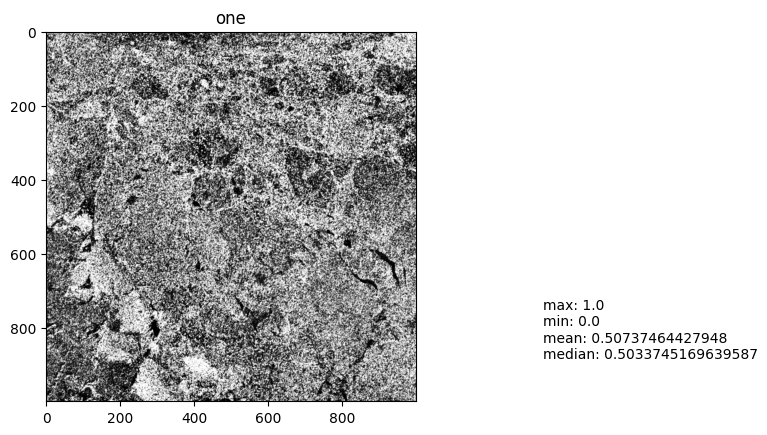

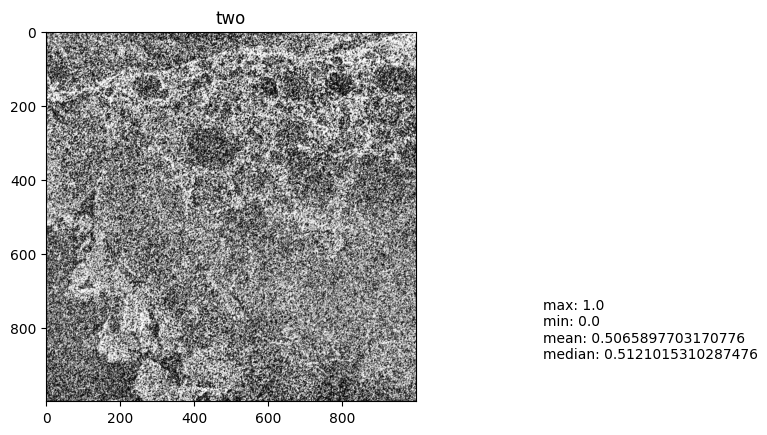

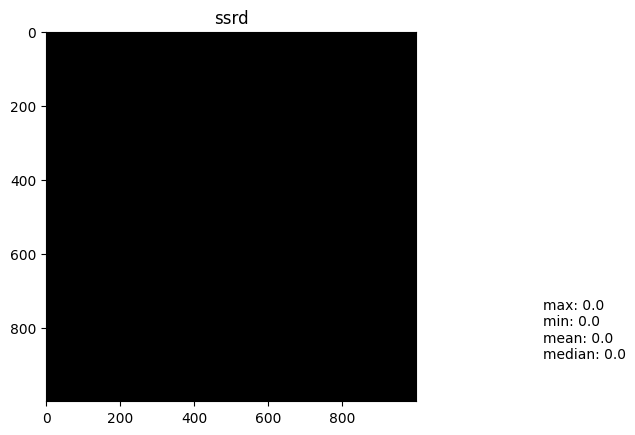

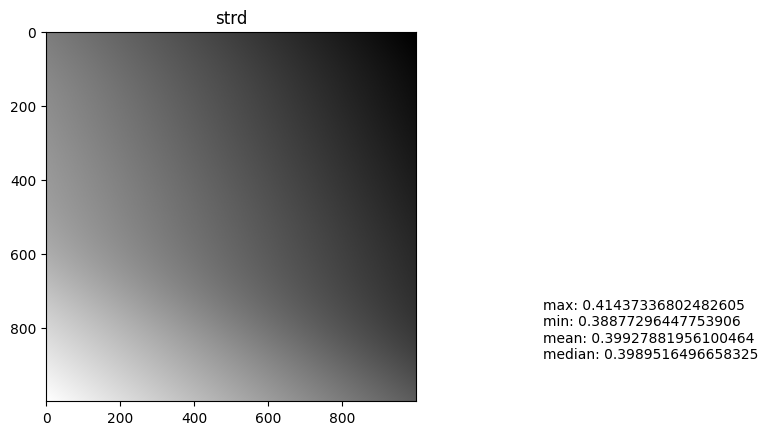

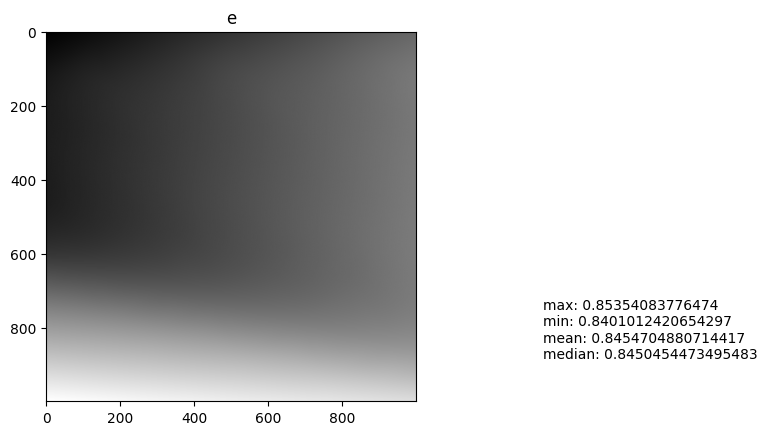

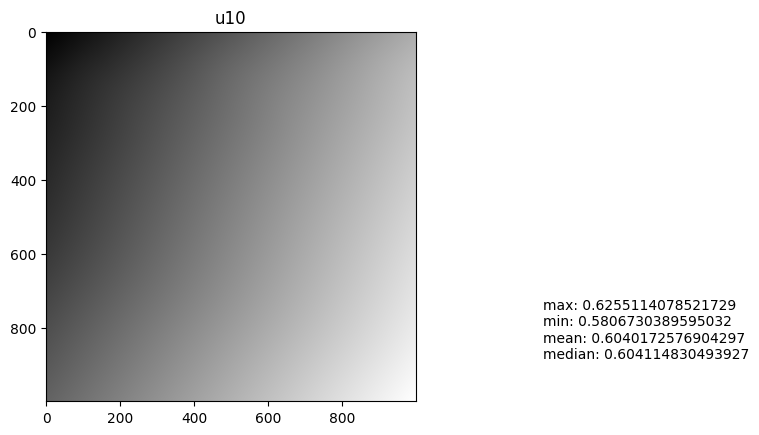

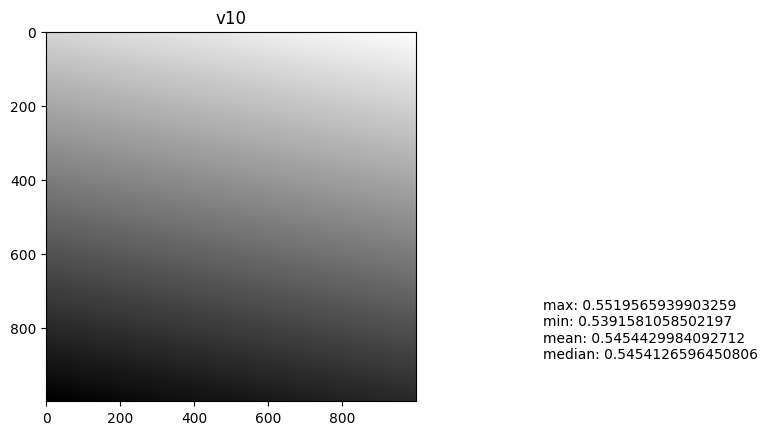

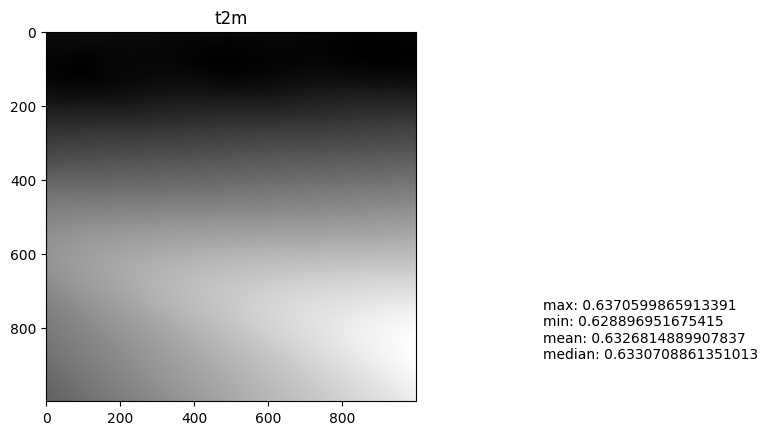

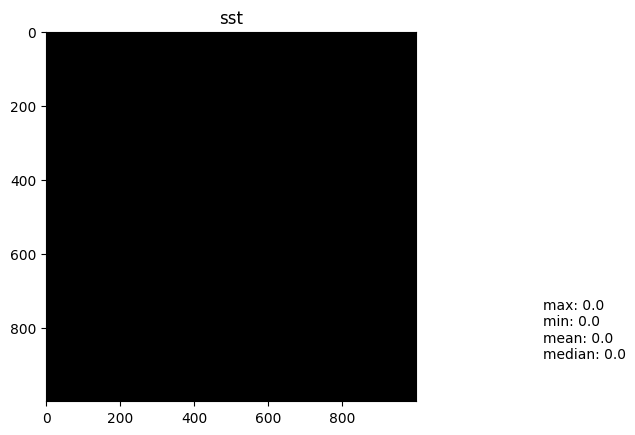

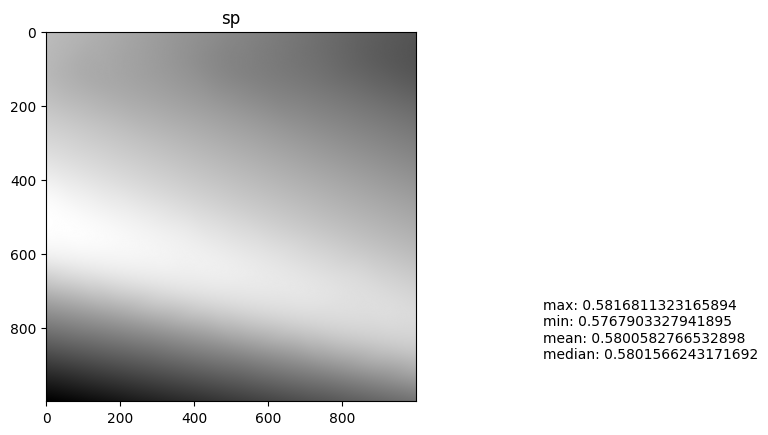

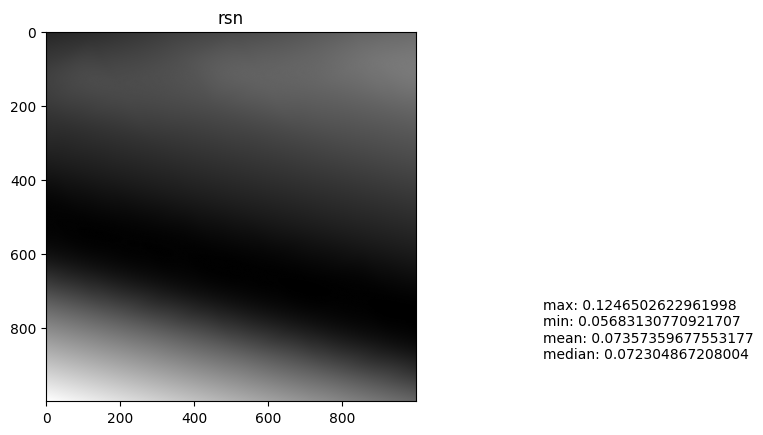

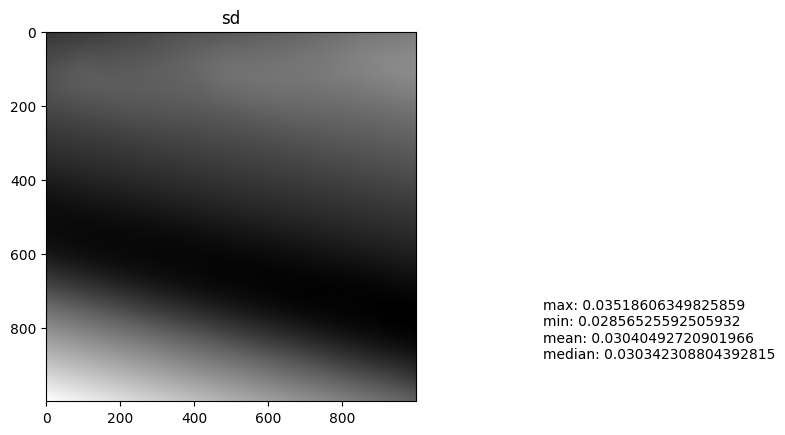

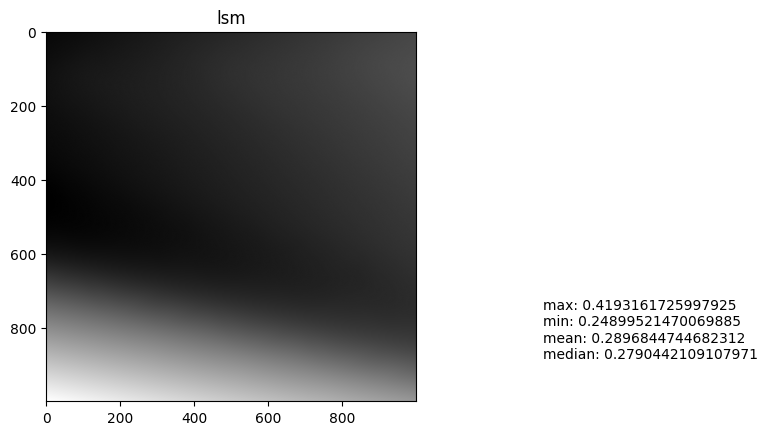

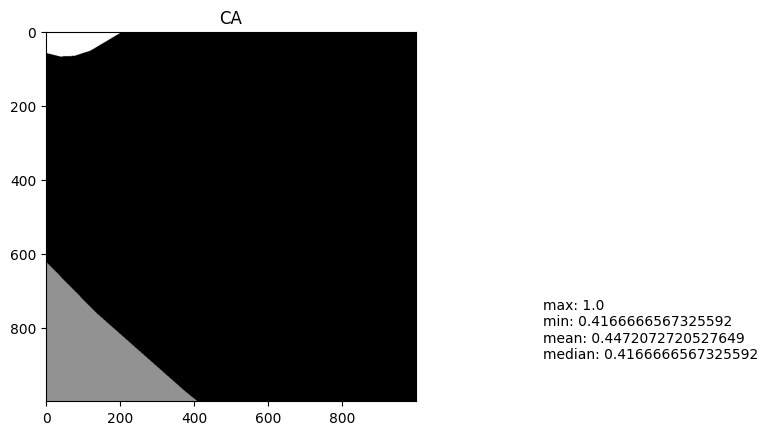

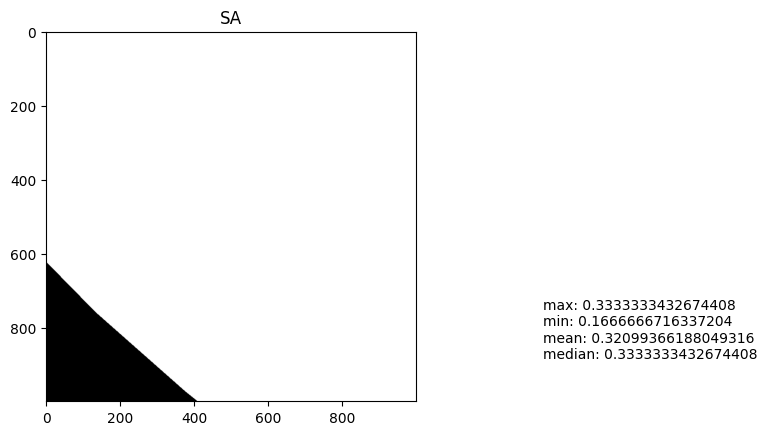

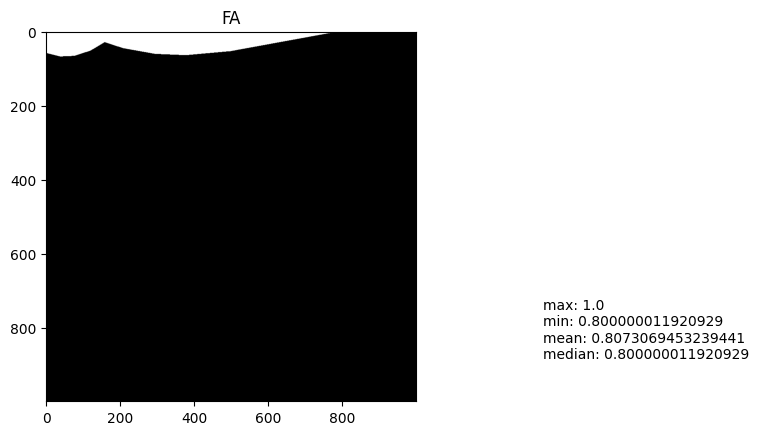

In [17]:
loader = DataLoader(dataset, batch_size=1)

def desc(s: torch.Tensor):
    return "\n".join([
        "max: " + str(s.max().item()),
        "min: " + str(s.min().item()),
        "mean: " + str(s.mean().item()),
        "median: " + str(s.median().item())
    ])

layers = dataset.getLayers()
for image, mask in loader:
    for i in range(image.shape[1]):
        plt.imshow(image[0][i], cmap='gray')
        plt.title(layers[0][i])
        plt.figtext(1, 0.2, desc(image[0][i]))
        plt.show()
    for i in range(mask.shape[1]):
        plt.imshow(mask[0][i], cmap='gray')
        plt.title(layers[1][i])
        plt.figtext(1, 0.2, desc(mask[0][i]))
        plt.show()
    break

# Метрики

In [10]:
def iou(y_pred: torch.Tensor, y_true: torch.Tensor):
    #with open('ice_types_dict.json', 'r', encoding='utf-8-sig') as f:
    #   ice_dict = json.load(f)['cifer']
    
    classesPerLayer = dataset.getClassesPerLayer()

    for batch in range(y_true.shape[0]):
        for i in range(len(classesPerLayer)):
            y_true[batch][i] *= classesPerLayer[i] - 1
            y_pred[batch][i] *= classesPerLayer[i] - 1
            
            y_true[batch][i] = torch.bucketize(y_true[batch][i], torch.tensor(range(classesPerLayer[i] - 1)))
            y_pred[batch][i] = torch.bucketize(y_pred[batch][i], torch.tensor(range(classesPerLayer[i] - 1)))

    y_true = y_true.int()
    y_pred = y_pred.int()

    layers = dataset.getLayers()

    answer = {}
    for i, layer in enumerate(layers[1]):
        tp, fp, fn, tn = smp.metrics.get_stats(y_pred[:, i, :, :], y_true[:, i, :, :], mode='multiclass', num_classes=classesPerLayer[i])
        answer[f"iou_{layer}"] = smp.metrics.iou_score(tp, fp, fn, tn).mean(dim=0)
        answer[f"f1_{layer}"] = smp.metrics.f1_score(tp, fp, fn, tn).mean(dim=0)
        answer[f"f2_{layer}"] = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2).mean(dim=0)
        answer[f"accuracy_{layer}"] = smp.metrics.accuracy(tp, fp, fn, tn).mean(dim=0)
        answer[f"recall_{layer}"] = smp.metrics.recall(tp, fp, fn, tn).mean(dim=0)

    return answer

# Функции ошибки

In [11]:
def bce_loss(y_pred, y_real):
    loss_val = y_pred - y_real * y_pred + torch.log(1 + torch.exp(-1 * y_pred))
    return loss_val.mean((1, 2, 3)).mean()

In [14]:
def dice_loss(y_pred, y_real):
    num = 2 * torch.sum(y_pred * y_real)
    den = torch.sum(y_pred) + torch.sum(y_real)
    res = 1 - ((num + 1e-5) / (den + 1e-5))
    return res.mean()

In [15]:
def focal_loss(y_pred, y_real, eps=1e-8, gamma=2):
    y_pred = torch.clip(y_pred, eps, 1 - eps)
    bce = y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))
    pt = torch.exp(-bce)
    focal = (1 - pt) ** gamma * bce
    return torch.mean(focal)

In [12]:
#loss_fn = torch.nn.CrossEntropyLoss()
#loss_fn = torch.nn.BCELoss()
loss_fn = bce_loss
#loss_fn = dice_loss
#loss_fn = focal_loss
#loss_fn = torch.nn.BCEWithLogitsLoss()

# Определение девайса

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

# Определение модели

In [14]:
os.environ['TORCH_HOME'] = 'models'

layers = dataset.getLayers()
model = smp.PSPNet(
    encoder_name='resnet50',
    #encoder_weights='imagenet',
    in_channels=len(layers[0]),
    psp_dropout=0.1,
    classes=len(layers[1]),
    activation='sigmoid'
).to(device)

# Оптимизатор

In [15]:
# Optimizers specified in the torch.optim package
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)
#optimizer = torch.optim.AdamW(model.parameters(), 1e-5)
optimizer = torch.optim.Adam(model.parameters(), 1e-5)

# Запуск MLFlow

In [20]:
ex = mlflow.set_experiment("test run 1")
#mlflow.pytorch.autolog()

# EarlyStopping callback

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, delta=0):
        self.patience = patience
        self.delta = delta
        #self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss)
            self.counter = 0

    def save_checkpoint(self, val_loss):
        self.val_loss_min = val_loss

ES = EarlyStopping()

# Цикл обучения

In [ ]:
best_vloss = 1e9
with mlflow.start_run(experiment_id=ex.experiment_id, run_name='test run 2') as run:
    for epoch in range(EPOCHS):
        print('EPOCH {}:'.format(epoch + 1))

        model.train(True)

        running_loss = 0.

        i = 0
        bar = tqdm(training_loader, desc='обучение')
        dataset.setTQDM(bar)
        for (inputs, labels) in bar:
            inputs = inputs.to(device)
            if len(inputs[inputs == torch.nan]) > 0:
                bar.write("inputs содержит nan")
            labels = labels.to(device)
            if len(labels[labels == torch.nan]) > 0:
                bar.write("labels содержит nan")
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            #bar.write(f"{i + 1}) avg loss: {running_loss / (i + 1)}; loss: {loss.item()}")
            i += 1
        
        avg_loss = running_loss / i


        running_vloss = 0.0
        #iou_sum = 0.
        iou_sum = 0
        model.eval()

        i = 0
        with torch.no_grad():
            bar = tqdm(validation_loader, desc='валидация')
            dataset.setTQDM(bar)
            for (vinputs, vlabels) in bar:
                vinputs = vinputs.to(device)
                vlabels = vlabels.to(device)
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)
                #iou_this = iou(voutputs.cpu(), vlabels.cpu())
                #iou_sum += iou_this
                running_vloss += vloss.item()
                #bar.write(f"{i + 1}) avg loss: {running_vloss / (i + 1)}; loss: {vloss.item()}\n\tavg iou: {iou_sum / (i + 1)}; iou: {iou_this}")

                iou_this = iou(voutputs.cpu(), vlabels.cpu())
                if iou_sum == 0:
                    iou_sum = iou_this
                else:
                    for k, v in iou_this.items():
                        iou_sum[k] += v
                i += 1

        avg_vloss = running_vloss / i
        ES(avg_loss)
        for k, v in iou_sum.items():
            iou_sum[k] = iou_sum[k].mean().item()

        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
        #mlflow.log_metric("train BCE loss", avg_loss)
        #mlflow.log_metric("val BCE loss", avg_vloss, step=epoch+1)
        mlflow.log_metrics({"train BCE loss": avg_loss, "val BCE loss": avg_vloss}, step=epoch+1)
        mlflow.log_metrics(iou_sum, step=epoch+1)
        #mlflow.log_param("iou", iou_sum / BATCH_SIZE)

        signature = infer_signature(vinputs.cpu().numpy(), voutputs.cpu().numpy())

        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            #model_best_path = f'{os.getcwd()}/mlruns/{ex.experiment_id}/{run.info.run_id}/artifacts/best ({epoch}).pt'
            model_best_path = "best.pt"
            torch.save({
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict()
                }, model_best_path)
            #mlflow.pytorch.log_model(model,
            #                         artifact_path=f"PSPNet best ({epoch})",
            #                         signature=signature,
            #                         input_example=input_example)
        model_last_path = "last.pt"
        torch.save({
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict()
            }, model_last_path)
        #mlflow.pytorch.log_model(model,
        #                         artifact_path="PSPNet last",
        #                         signature=signature,
        #                         input_example=input_example)

        epoch += 1
        if ES.early_stop:
            break

EPOCH 1:


валидация: 100%|██████████| 82/82 [09:10<00:00,  6.71s/it]


LOSS train 0.6443786380138803 valid 0.6176229359173193
EPOCH 2:


валидация: 100%|██████████| 82/82 [08:52<00:00,  6.49s/it]


LOSS train 0.6283738636680649 valid 0.6126398418734713
EPOCH 3:


валидация: 100%|██████████| 82/82 [09:02<00:00,  6.62s/it]


LOSS train 0.623844775023069 valid 0.6116598877238064
EPOCH 4:


валидация: 100%|██████████| 82/82 [09:31<00:00,  6.97s/it]


LOSS train 0.6225977811769874 valid 0.6106267353383507
EPOCH 5:


валидация: 100%|██████████| 82/82 [08:53<00:00,  6.50s/it]


LOSS train 0.6201938336381072 valid 0.60768174870712
EPOCH 6:


валидация: 100%|██████████| 82/82 [08:49<00:00,  6.46s/it]


LOSS train 0.620309201960868 valid 0.609223534421223
EPOCH 7:


валидация: 100%|██████████| 82/82 [08:35<00:00,  6.28s/it]


LOSS train 0.61896873516877 valid 0.6059891170844799
EPOCH 8:


валидация: 100%|██████████| 82/82 [09:30<00:00,  6.95s/it]


LOSS train 0.6183870577884663 valid 0.6064518966325899
EPOCH 9:


валидация: 100%|██████████| 82/82 [08:58<00:00,  6.57s/it]


LOSS train 0.6176260956152594 valid 0.6053242083729767
EPOCH 10:


валидация: 100%|██████████| 82/82 [08:42<00:00,  6.38s/it]


LOSS train 0.6162819007247414 valid 0.605025325969952
EPOCH 11:


валидация: 100%|██████████| 82/82 [09:13<00:00,  6.74s/it]


LOSS train 0.6156912071001929 valid 0.6066590896466884
EPOCH 12:


валидация: 100%|██████████| 82/82 [08:35<00:00,  6.28s/it]


LOSS train 0.6154401017902108 valid 0.605853638997892
EPOCH 13:


валидация: 100%|██████████| 82/82 [09:27<00:00,  6.92s/it]


LOSS train 0.6151572168779228 valid 0.6049623805575255
EPOCH 14:


валидация: 100%|██████████| 82/82 [09:18<00:00,  6.81s/it]


LOSS train 0.6150273231387501 valid 0.6073901264405832
EPOCH 15:


валидация: 100%|██████████| 82/82 [09:20<00:00,  6.83s/it]


LOSS train 0.6152211681325385 valid 0.604075402384851
EPOCH 16:


валидация: 100%|██████████| 82/82 [08:54<00:00,  6.52s/it]


LOSS train 0.6141862990646014 valid 0.6041623997252162
EPOCH 17:


валидация: 100%|██████████| 82/82 [09:26<00:00,  6.91s/it]


LOSS train 0.6129844816441231 valid 0.6043357801873509
EPOCH 18:


валидация: 100%|██████████| 82/82 [09:24<00:00,  6.89s/it]


LOSS train 0.6135355047541912 valid 0.6044680617931413
EPOCH 19:


валидация: 100%|██████████| 82/82 [09:49<00:00,  7.19s/it]


LOSS train 0.6121608424693981 valid 0.6041446680702814
EPOCH 20:


валидация: 100%|██████████| 82/82 [09:11<00:00,  6.73s/it]


LOSS train 0.6132511692206548 valid 0.6046598266537596
EPOCH 21:


валидация: 100%|██████████| 82/82 [09:29<00:00,  6.95s/it]


LOSS train 0.6130188193545878 valid 0.6032707080608462
EPOCH 22:


валидация: 100%|██████████| 82/82 [09:32<00:00,  6.98s/it]


LOSS train 0.611947555853603 valid 0.6058388152500478
EPOCH 23:


валидация: 100%|██████████| 82/82 [08:59<00:00,  6.58s/it]


LOSS train 0.6117828785467293 valid 0.6050154948379936
EPOCH 24:


валидация: 100%|██████████| 82/82 [08:38<00:00,  6.32s/it]


LOSS train 0.6115114357333777 valid 0.6067052461752077
EPOCH 25:


валидация: 100%|██████████| 82/82 [08:56<00:00,  6.55s/it]


LOSS train 0.6118189589230848 valid 0.6051976931531254
EPOCH 26:


валидация: 100%|██████████| 82/82 [09:12<00:00,  6.74s/it]


LOSS train 0.611247812179809 valid 0.6069269678214702
EPOCH 27:


валидация: 100%|██████████| 82/82 [08:49<00:00,  6.46s/it]


LOSS train 0.6108991748293845 valid 0.6043611139785953
EPOCH 28:


валидация: 100%|██████████| 82/82 [09:10<00:00,  6.71s/it]


LOSS train 0.6103030292821148 valid 0.6061171485883433
EPOCH 29:


валидация: 100%|██████████| 82/82 [09:00<00:00,  6.59s/it]


LOSS train 0.6104627632080241 valid 0.6031161186898627
EPOCH 30:


валидация: 100%|██████████| 82/82 [08:38<00:00,  6.33s/it]


LOSS train 0.6108161375877705 valid 0.6046938932523495
EPOCH 31:


валидация: 100%|██████████| 82/82 [08:47<00:00,  6.43s/it]


LOSS train 0.6100502859314162 valid 0.6023600563043501
EPOCH 32:


валидация: 100%|██████████| 82/82 [09:42<00:00,  7.11s/it]


LOSS train 0.6104262934992016 valid 0.6038045955867302
EPOCH 33:


валидация: 100%|██████████| 82/82 [09:12<00:00,  6.74s/it]


LOSS train 0.6098989233782226 valid 0.6090458507944898
EPOCH 34:


валидация: 100%|██████████| 82/82 [09:32<00:00,  6.99s/it]


LOSS train 0.6100550991423587 valid 0.6051253650973483
EPOCH 35:


валидация: 100%|██████████| 82/82 [09:07<00:00,  6.68s/it]


LOSS train 0.6089646818065353 valid 0.6021627918249224
EPOCH 36:


валидация: 100%|██████████| 82/82 [08:59<00:00,  6.57s/it]


LOSS train 0.6098442371130715 valid 0.6052783389643925
EPOCH 37:


валидация: 100%|██████████| 82/82 [09:15<00:00,  6.77s/it]


LOSS train 0.6088205402926471 valid 0.6031738508765291
EPOCH 38:


валидация: 100%|██████████| 82/82 [09:29<00:00,  6.94s/it]


LOSS train 0.6092559757747187 valid 0.6075009020363412
EPOCH 39:


валидация: 100%|██████████| 82/82 [09:18<00:00,  6.82s/it]


LOSS train 0.6091423176885739 valid 0.6026155945004487
EPOCH 40:


валидация: 100%|██████████| 82/82 [08:50<00:00,  6.47s/it]


LOSS train 0.6085206397036289 valid 0.6030944567628023
EPOCH 41:


валидация: 100%|██████████| 82/82 [09:03<00:00,  6.62s/it]


LOSS train 0.6087377817797444 valid 0.6048329399853218
EPOCH 42:


валидация: 100%|██████████| 82/82 [08:55<00:00,  6.53s/it] 


LOSS train 0.6094063186174468 valid 0.6040384286060566
EPOCH 43:


валидация: 100%|██████████| 82/82 [08:51<00:00,  6.48s/it]


LOSS train 0.6088342626768767 valid 0.6054086939590734
EPOCH 44:


валидация: 100%|██████████| 82/82 [09:53<00:00,  7.24s/it]


LOSS train 0.6076107594017562 valid 0.6039734878918019
EPOCH 45:


валидация: 100%|██████████| 82/82 [09:06<00:00,  6.67s/it]


LOSS train 0.6089352971695839 valid 0.6025508878434577
EPOCH 46:


валидация: 100%|██████████| 82/82 [09:20<00:00,  6.83s/it]


LOSS train 0.6076450441202494 valid 0.6081481416050981
EPOCH 47:


валидация: 100%|██████████| 82/82 [09:55<00:00,  7.26s/it]


LOSS train 0.608444697951111 valid 0.6033131327570939
EPOCH 48:


валидация: 100%|██████████| 82/82 [09:12<00:00,  6.74s/it]


LOSS train 0.6076498925685883 valid 0.6070112309804777
EPOCH 49:


валидация: 100%|██████████| 82/82 [09:05<00:00,  6.66s/it]


LOSS train 0.6081193244384777 valid 0.6091073940439922
EPOCH 50:


валидация: 100%|██████████| 82/82 [09:10<00:00,  6.71s/it]


LOSS train 0.6081341984243016 valid 0.6061984667690788
EPOCH 51:


валидация: 100%|██████████| 82/82 [09:11<00:00,  6.73s/it]


LOSS train 0.6076681822266622 valid 0.6100425062383094
EPOCH 52:


валидация: 100%|██████████| 82/82 [08:57<00:00,  6.56s/it]


LOSS train 0.6078228361700806 valid 0.6043261642136225
EPOCH 53:


валидация: 100%|██████████| 82/82 [08:39<00:00,  6.34s/it]


LOSS train 0.6079824816854529 valid 0.6036449347327395
EPOCH 54:


валидация: 100%|██████████| 82/82 [09:08<00:00,  6.69s/it]


LOSS train 0.6085823411999502 valid 0.604889328886823
EPOCH 55:


валидация: 100%|██████████| 82/82 [09:23<00:00,  6.87s/it]


LOSS train 0.6075077459080241 valid 0.6076962173711963
EPOCH 56:


валидация: 100%|██████████| 82/82 [09:32<00:00,  6.98s/it]


LOSS train 0.6080659102523943 valid 0.6067331044412241
EPOCH 57:


валидация: 100%|██████████| 82/82 [09:37<00:00,  7.05s/it]


LOSS train 0.6075848103656595 valid 0.6041084542507078
EPOCH 58:


валидация: 100%|██████████| 82/82 [09:29<00:00,  6.95s/it]


LOSS train 0.6064896863463439 valid 0.6035063477551065
EPOCH 59:


валидация: 100%|██████████| 82/82 [09:13<00:00,  6.75s/it]


LOSS train 0.6075417876787099 valid 0.6062891839480982
EPOCH 60:


валидация: 100%|██████████| 82/82 [09:14<00:00,  6.76s/it]


LOSS train 0.6064117810827621 valid 0.607271308579096
EPOCH 61:


валидация: 100%|██████████| 82/82 [09:13<00:00,  6.75s/it]


LOSS train 0.6068026929822011 valid 0.609038275189516
EPOCH 62:


валидация: 100%|██████████| 82/82 [08:57<00:00,  6.55s/it]


LOSS train 0.6070173613749739 valid 0.6079082925145219
EPOCH 63:


валидация: 100%|██████████| 82/82 [08:40<00:00,  6.35s/it]


LOSS train 0.6058077812194824 valid 0.6064586832029063
EPOCH 64:


валидация: 100%|██████████| 82/82 [10:15<00:00,  7.50s/it]


LOSS train 0.606707586887035 valid 0.6071824304214338
EPOCH 65:


валидация: 100%|██████████| 82/82 [10:23<00:00,  7.60s/it]


LOSS train 0.6065633639376214 valid 0.6044126872609301
EPOCH 66:


валидация: 100%|██████████| 82/82 [09:14<00:00,  6.76s/it]


LOSS train 0.6069214620307586 valid 0.6054607920530366
EPOCH 67:


валидация: 100%|██████████| 82/82 [08:56<00:00,  6.55s/it]


LOSS train 0.6072892559335586 valid 0.6064327046638582
EPOCH 68:


валидация: 100%|██████████| 82/82 [09:16<00:00,  6.79s/it]


LOSS train 0.6056738667937398 valid 0.6027523082930867
EPOCH 69:


валидация: 100%|██████████| 82/82 [09:16<00:00,  6.79s/it]


LOSS train 0.606243776333006 valid 0.6051845452407512
EPOCH 70:


валидация: 100%|██████████| 82/82 [09:02<00:00,  6.62s/it]


LOSS train 0.6054862253934055 valid 0.6071217408994349
🏃 View run test run 2 at: http://localhost:5000/#/experiments/285988308402798695/runs/23122ff994644a9f829abb75de00001e
🧪 View experiment at: http://localhost:5000/#/experiments/285988308402798695


# Загрузка весов модели

In [16]:
model.load_state_dict(torch.load('best.pt')['model_state_dict'])

<All keys matched successfully>

# Тест модели

In [17]:
vinputs, vlabels = dataset.getItemByName("3CEC_128")

In [18]:
vinputs = vinputs[None,:,:,:]
vlabels = vlabels[None,:,:,:]

In [33]:
model.eval()
with torch.no_grad():
    vinputs = vinputs.to(device)
    voutputs = model(vinputs)
    iou_this = iou(voutputs.cpu(), vlabels)
iou_this

{'iou_CA': tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.]),
 'f1_CA': tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.]),
 'f2_CA': tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.]),
 'accuracy_CA': tensor([1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.]),
 'recall_CA': tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.]),
 'iou_SA': tensor([1., 0., 1., 1., 1., 1., 0.]),
 'f1_SA': tensor([1., 0., 1., 1., 1., 1., 0.]),
 'f2_SA': tensor([1., 0., 1., 1., 1., 1., 0.]),
 'accuracy_SA': tensor([1., 0., 1., 1., 1., 1., 0.]),
 'recall_SA': tensor([1., 1., 1., 1., 1., 1., 0.]),
 'iou_FA': tensor([1., 0., 1., 1., 1., 0.]),
 'f1_FA': tensor([1., 0., 1., 1., 1., 0.]),
 'f2_FA': tensor([1., 0., 1., 1., 1., 0.]),
 'accuracy_FA': tensor([1., 0., 1., 1., 1., 0.]),
 'recall_FA': tensor([1., 1., 1., 1., 1., 0.])}

In [34]:
for k, v in iou_this.items():
    iou_this[k] = iou_this[k].mean(dim=0).item()
iou_this

{'iou_CA': 0.8461538553237915,
 'f1_CA': 0.8461538553237915,
 'f2_CA': 0.8461538553237915,
 'accuracy_CA': 0.8461538553237915,
 'recall_CA': 0.9230769276618958,
 'iou_SA': 0.7142857313156128,
 'f1_SA': 0.7142857313156128,
 'f2_SA': 0.7142857313156128,
 'accuracy_SA': 0.7142857313156128,
 'recall_SA': 0.8571428656578064,
 'iou_FA': 0.6666666865348816,
 'f1_FA': 0.6666666865348816,
 'f2_FA': 0.6666666865348816,
 'accuracy_FA': 0.6666666865348816,
 'recall_FA': 0.8333333134651184}

[5]


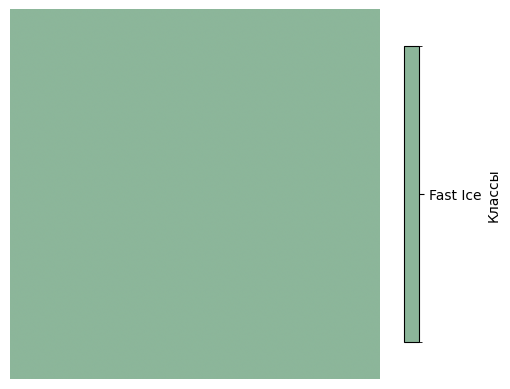

[1]


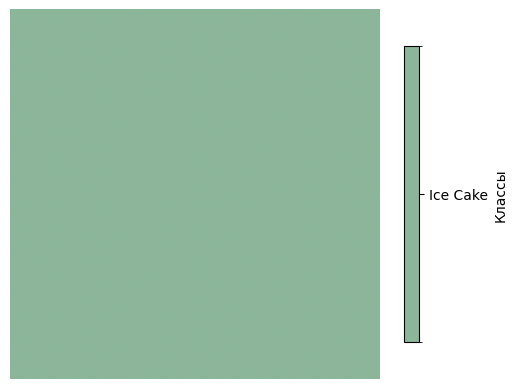

In [37]:
import matplotlib.colors as mcolors

def desc(s: torch.Tensor):
    return "\n".join([
        "max: " + str(s.max().item()),
        "min: " + str(s.min().item()),
        "mean: " + str(s.mean().item()),
        "median: " + str(s.median().item())
    ])

def evaluate(a: torch.Tensor):
    classesPerLayer = dataset.getClassesPerLayer()

    for batch in range(a.shape[0]):
        for i in range(len(classesPerLayer)):
            a[batch][i] *= classesPerLayer[i] - 1
            
            a[batch][i] = torch.bucketize(a[batch][i], torch.tensor(range(classesPerLayer[i] - 1)))

    return a.int()

def showIMG(a:torch.Tensor, batch=0, layer=0):
    #classesPerLayer = dataset.getClassesPerLayer()
    labels = evaluate(a.cpu())[batch][layer]
    classes = np.unique(labels)
    print(classes)

    np.random.seed(0)
    class_colors = {
        int(i): mcolors.to_hex(np.random.rand(3))  # Генерируем случайный цвет в HEX
        for i in classes
    }

    cmap = mcolors.ListedColormap([class_colors[i] for i in classes])
    bounds = np.arange(len(classes) + 1) - 0.5
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    fig, ax = plt.subplots()
    im = ax.imshow(labels, cmap=cmap, norm=norm)
    ax.axis('off')

    cbar = plt.colorbar(
        im,
        ax=ax,
        ticks=np.arange(len(classes)),
        spacing="uniform",
        shrink=0.8,
    )
    cbar.set_label("Классы")
    with open('ice_types_dict.json', 'r', encoding='utf-8-sig') as f:
        ice_dict = json.load(f)['cifer']
    layers = dataset.getLayers()[1]
    layers = [i[0] for i in layers]
    cbar.ax.set_yticklabels([ice_dict[layers[layer]][[i for i in ice_dict[layers[layer]].keys() if not i in ('-9', '99')][i]] for i in classes])

    plt.show()

batch = 0
layer = 2

showIMG(vlabels, batch, layer)
showIMG(voutputs, batch, layer)

# Схема модели

In [47]:
summary(model=model,
        input_size=(4, 13, 1000, 1000), # make sure this is "input_size", not "input_shape"
        #col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
PSPNet (PSPNet)                                         [4, 13, 1000, 1000]  [4, 3, 1000, 1000]   --                   True
├─ResNetEncoder (encoder)                               [4, 13, 1000, 1000]  [4, 13, 1000, 1000]  22,063,104           True
│    └─Conv2d (conv1)                                   [4, 13, 1000, 1000]  [4, 64, 500, 500]    40,768               True
│    └─BatchNorm2d (bn1)                                [4, 64, 500, 500]    [4, 64, 500, 500]    128                  True
│    └─ReLU (relu)                                      [4, 64, 500, 500]    [4, 64, 500, 500]    --                   --
│    └─MaxPool2d (maxpool)                              [4, 64, 500, 500]    [4, 64, 250, 250]    --                   --
│    └─Sequential (layer1)                              [4, 64, 250, 250]    [4, 256, 250, 250]   --                   True
│    │ 

In [ ]:
dummy_img = torch.rand(1, 8, 256, 256)
outputs = model(dummy_img)
print(outputs[0].shape)

torch.Size([9, 256, 256])


[-3.5977864 -3.5907054 -3.5554626 ...  2.2468061  2.295901   2.32313  ]


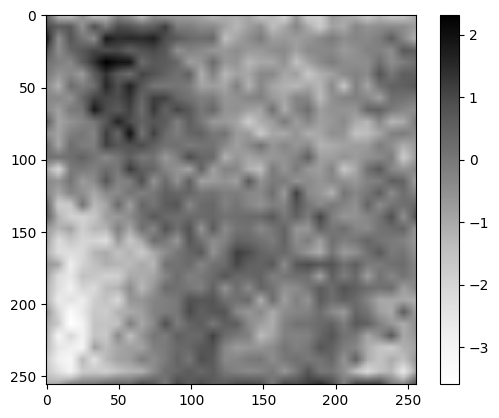

In [ ]:
im = outputs[0][0].detach().numpy()
print(np.unique(im))
plt.imshow(im, cmap='Greys')
plt.colorbar()

# Вывести пробный пакет картинок из набора

Найдено 182 изображений в подкаталоге vh.
Найдено 182 изображений.
Найдено 182 масок.


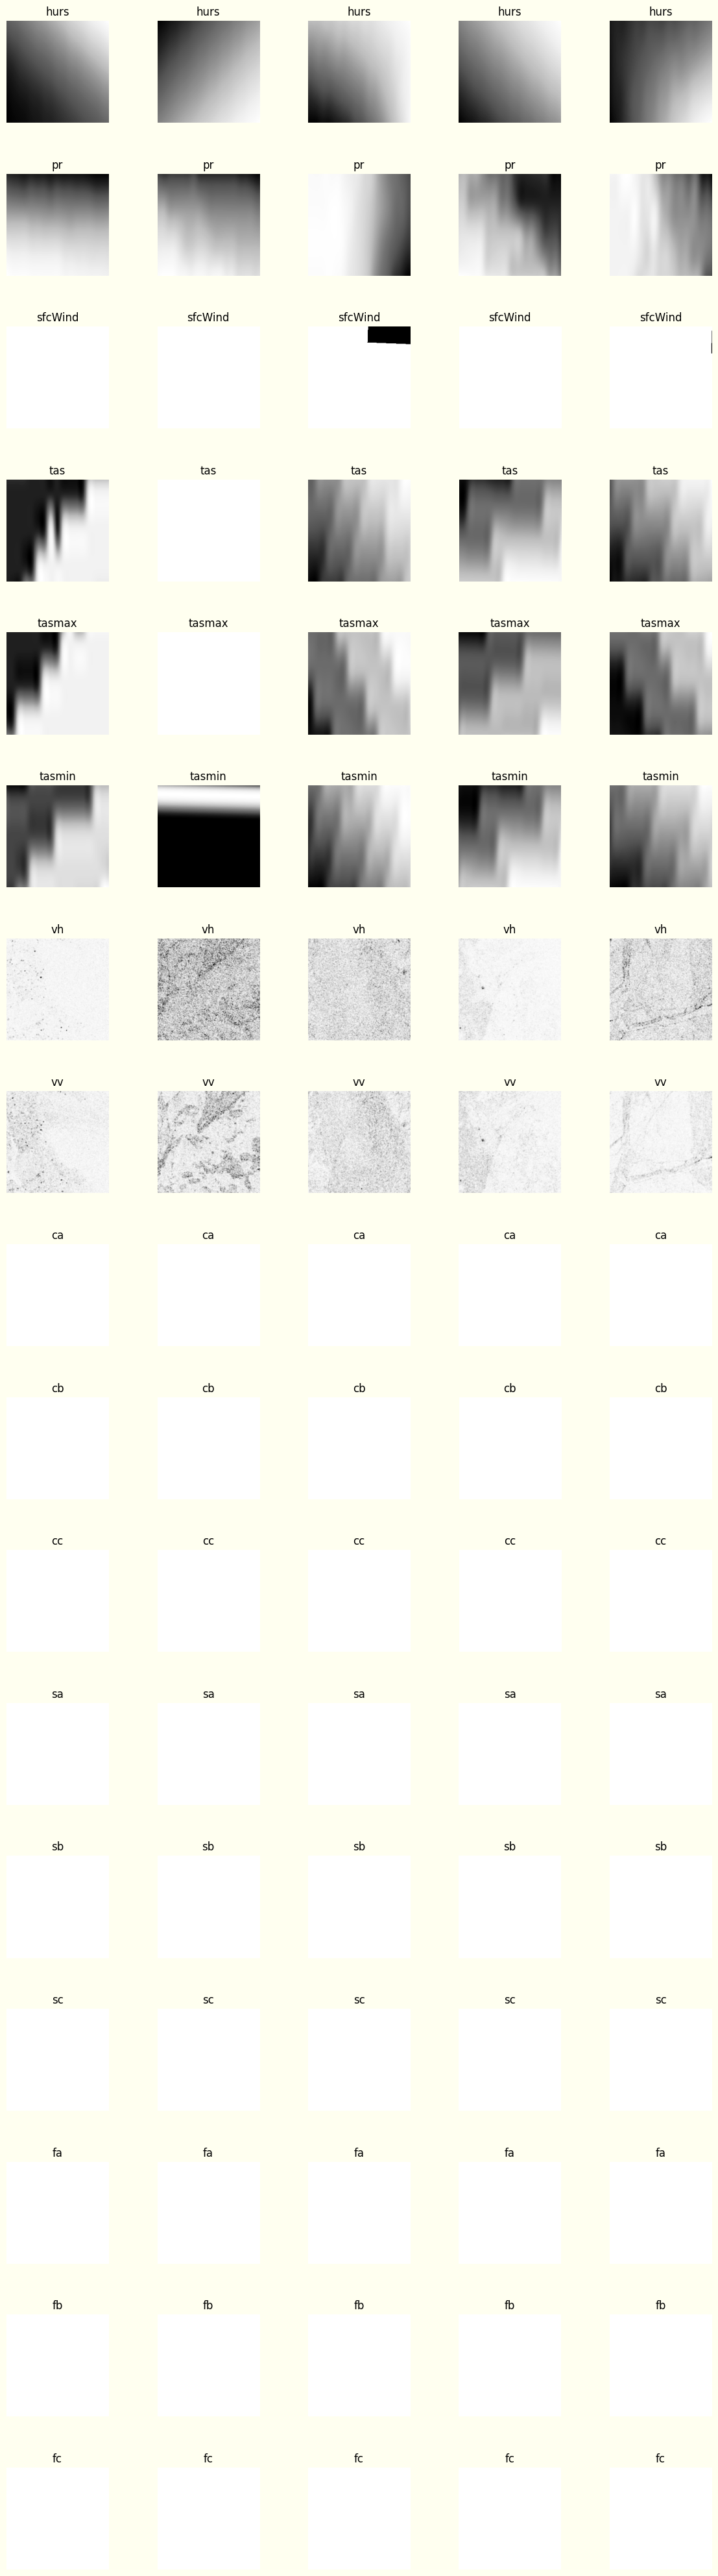

In [ ]:
dataset = MyDataset(
    image_root=f"{os.getcwd()}/datasets/dataset1/images",
    mask_root=f"{os.getcwd()}/datasets/dataset1/labels",
    transform=[T.ToTensor(), T.ToTensor()]  # Добавляем аугментацию
)

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

plt.figure(figsize=(15, 51), facecolor='ivory')
gs = grids.GridSpec(17, 5)
gs.update(wspace=0, hspace=0.5)

titles = MyDataset.layerNames + MyDataset.maskNames
for i, (image, mask) in enumerate(dataloader):
    for j in range(image.shape[1]):
        ax = plt.subplot(gs[j * 5 + i])
        ax.imshow(image[0][j], cmap="Greys")
        ax.set_title(titles[0 + j])
        ax.axis('off')
        ax.set_aspect('equal')
    for j in range(mask.shape[1]):
        ax = plt.subplot(gs[(image.shape[1] + j) * 5 + i])
        ax.imshow(mask[0][j], cmap="Greys")
        ax.set_title(titles[image.shape[1] + j])
        ax.axis('off')
        ax.set_aspect('equal')
    
    if i == 4:  # Останавливаемся после 5 примеров
        break